In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from itertools import chain, product

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(42)

In [2]:
device

device(type='cuda')

In [3]:
def plot_manifold(latent_r, labels=None, alpha=0.9, classes=None):
    plt.figure(figsize=(10, 10))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], cmap="tab10", alpha=alpha)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        cbar = plt.colorbar()
    if classes:
        cbar.ax.set_yticklabels(classes)
    plt.show()


# plotting reconstructed and noised images
def plot_samples(*args, invert_colors=True, digit_size=28, name=None):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    if invert_colors:
        figure = 1 - figure

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap="Greys_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()


def train(
    encoder,
    decoder,
    loader,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
    log_interval=500,
):
    for batch_idx, (data, lab) in enumerate(loader):
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)
        lab = lab.to(device)

        latent, output = single_pass_handler(encoder, decoder, data, lab)

        loss = loss_handler(data, output, latent)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                    loss.item(),
                )
            )


# return reconstructed image, use to compute loss
def ae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    recons = decoder(latent)
    return latent, recons


# loss function
def ae_loss_handler(data, recons, *args, **kwargs):
    return F.binary_cross_entropy(recons, data)


# return result in numpy to visualization
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recontr=True,
    return_latent=True,
    return_labels=True,
):

    if return_real:
        real = []
    if return_recontr:
        reconstr = []
    if return_latent:
        latent = []
    if return_labels:
        labels = []
    with torch.no_grad():
        for batch_idx, (data, lab) in enumerate(loader):
            if return_labels:
                labels.append(lab.numpy())
            if return_real:
                real.append(data.numpy())

            data = data.to(device)
            lab = lab.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data, lab)
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recontr:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recontr:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    if return_labels:
        labels = np.concatenate(labels)
        result["labels"] = labels
    return result

In [4]:
import torch.nn as nn

# autoencoder model
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        modules = []
        in_channels = 1
        for h_dim in hidden_dims[:-1]:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(),
            )
        )
        modules.append(nn.Flatten())
        modules.append(nn.Linear(hidden_dims[-1] * 4, latent_size))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32]
        self.linear = nn.Linear(in_features=latent_size, out_features=hidden_dims[0])

        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    hidden_dims[-1],
                    hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 512, 1, 1)
        x = self.decoder(x)
        return x

In [5]:
from IPython.display import clear_output

!pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git
clear_output()

  0%|          | 0/3291041 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/retinamnist.npz


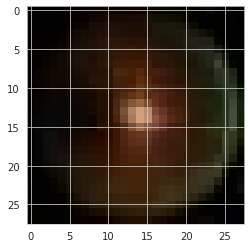

In [6]:
import medmnist
from medmnist import INFO  # , Evaluator
import matplotlib.pyplot as plt

DataClass = getattr(medmnist, INFO["retinamnist"]["python_class"])

train_retina_dataset = DataClass(split="train", download=True)
val_retina_dataset = DataClass(split="val", download=True)

plt.imshow(val_retina_dataset[0][0])

In [59]:
info = val_retina_dataset.info
info

{'python_class': 'RetinaMNIST',
 'description': 'The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/retinamnist.npz?download=1',
 'MD5': 'bd4c0672f1bba3e3a89f0e4e876791e4',
 'task': 'ordinal-regression',
 'label': {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'},
 'n_channels': 3,
 'n_samples': {'train': 1080, 'val': 120, 'test': 400},
 'license': 'CC BY 4.0'}

In [8]:
print("labels", val_retina_dataset.labels.shape)
print("images", val_retina_dataset.imgs.shape)

labels (120, 1)
images (120, 28, 28, 3)


In [9]:
def cast2torch(ds):
    ds.targets = ds.labels
    ds.data = ds.imgs
    ds.classes = list(info["label"].values())


cast2torch(val_retina_dataset)
cast2torch(train_retina_dataset)

In [11]:
# method for display all class samples from dataset
def show_ds(ds):
    fig, axs = plt.subplots(1, len(ds.classes), figsize=(20, 5))
    for cls_num, name in enumerate(ds.classes):
        i = np.argwhere(ds.targets == cls_num)[0][0]
        inverted = 255 - ds.data[i]
        ax = axs[cls_num]
        ax.imshow(inverted, cmap="Greys_r")
        ax.set_title(name)
        ax.axis("off")
    plt.show()

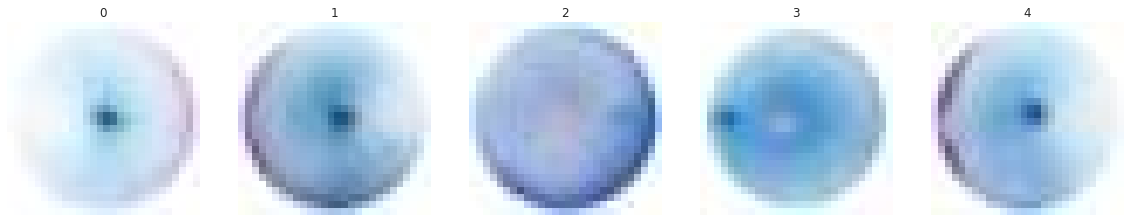

In [12]:
show_ds(val_retina_dataset)

In [13]:
DataClass = getattr(medmnist, INFO["bloodmnist"]["python_class"])
test_blood_dataset = DataClass(split="test", download=True)
cast2torch(test_blood_dataset)

  0%|          | 0/35461855 [00:00<?, ?it/s]

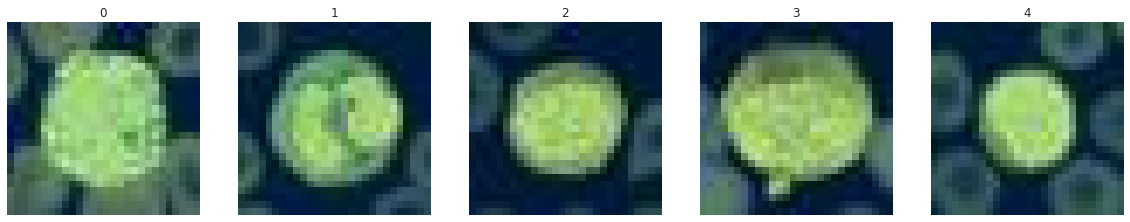

In [14]:
show_ds(test_blood_dataset)

In [15]:
from torch.utils.data import DataLoader
from torchvision import transforms


data_transform = transforms.Compose(
    [
        # Convert all images to Grayscale fo sake of MNIST compatibility
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)

train_retina_dataset.transform = data_transform
val_retina_dataset.transform = data_transform
test_blood_dataset.transform = data_transform

# encapsulate data into dataloader form
train_loader = DataLoader(train_retina_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_retina_dataset, batch_size=1, shuffle=False)
blood_loader = DataLoader(test_blood_dataset, batch_size=1, shuffle=False)

In [16]:
latent_dim = 2 # size of latent space
learning_rate = 1e-4 
encoder = Encoder(latent_size=latent_dim)
decoder = Decoder(latent_size=latent_dim)

encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)

In [19]:
# Train
for i in range(1, 10):
    train(
        encoder=encoder,
        decoder=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=ae_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/1080 (0%)]	Loss: 0.461650
Train Epoch: 2 [0/1080 (0%)]	Loss: 0.469369
Train Epoch: 3 [0/1080 (0%)]	Loss: 0.467117
Train Epoch: 4 [0/1080 (0%)]	Loss: 0.465137
Train Epoch: 5 [0/1080 (0%)]	Loss: 0.474794
Train Epoch: 6 [0/1080 (0%)]	Loss: 0.469947
Train Epoch: 7 [0/1080 (0%)]	Loss: 0.469772
Train Epoch: 8 [0/1080 (0%)]	Loss: 0.471172
Train Epoch: 9 [0/1080 (0%)]	Loss: 0.456265


In [21]:
encoder = encoder.eval()
decoder = decoder.eval()

In [22]:
run_res = run_eval(encoder, decoder, val_loader, ae_pass_handler)

In [41]:
def plot_pic(*args, invert_colors=True, digit_size=28, name=None, single_size=2):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    if invert_colors:
        figure = 1 - figure

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="Greys_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()

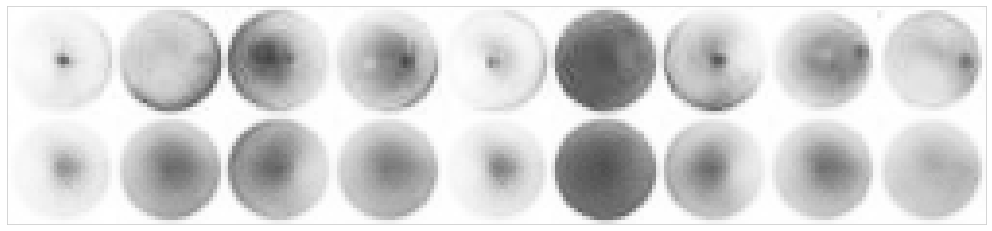

In [42]:
plot_pic(run_res['real'][0:9], run_res['reconstr'][0:9])

In [43]:
reconstr = torch.tensor(run_res['reconstr'])
real = torch.tensor(run_res['real'])
loss_retina = F.binary_cross_entropy(reconstr, real)

In [44]:
run_res = run_eval(encoder, decoder, blood_loader, ae_pass_handler)

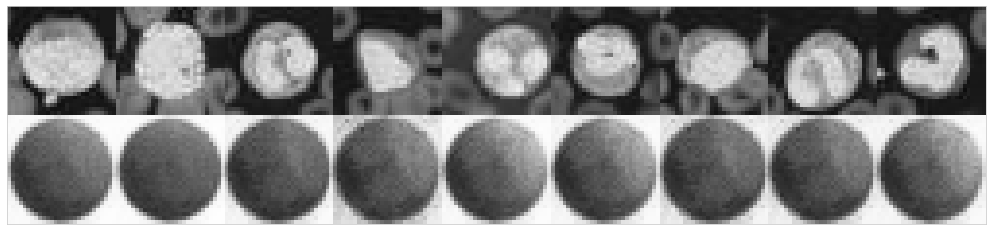

In [45]:
plot_pic(run_res['real'][0:9], run_res['reconstr'][0:9])

In [46]:
reconstr = torch.tensor(run_res['reconstr'])
real = torch.tensor(run_res['real'])
loss_blood = F.binary_cross_entropy(reconstr, real)

In [47]:
print(f'Loss on retina {loss_retina}')
print(f'Loss on blood {loss_blood}')

Loss on retina 0.4669610857963562
Loss on blood 0.896140992641449


In [48]:
border_loss = (loss_blood+loss_retina)/2
print(f'Border Loss {border_loss}')

Border Loss 0.6815510392189026


In [50]:
count_blood = 0
for i in range(3421):
    one_loss_blood = F.binary_cross_entropy(reconstr[i], real[i])
    if one_loss_blood > border_loss:
      count_blood += 1

In [52]:
run_res = run_eval(encoder, decoder, val_loader, ae_pass_handler)

In [53]:
reconstr = torch.tensor(run_res['reconstr'])
real = torch.tensor(run_res['real'])
loss_blood = F.binary_cross_entropy(reconstr, real)

In [55]:
count_retina = 0
for i in range(120):
    one_loss_blood = F.binary_cross_entropy(reconstr[i], real[i])
    if one_loss_blood > border_loss:
      count_retina += 1

In [56]:
acc_blood = count_blood/3421
acc_retina = count_retina/120

In [57]:
print(f'{count_retina} images out of 120 were droped in retina dataset ({"%.2f" % acc_retina}%)')
print(f'{count_blood} images out of 3421 were droped in blood dataset ({"%.2f" % acc_blood}%)')

0 images out of 120 were droped in retina dataset (0.00%)
3270 images out of 3421 were droped in blood dataset (0.96%)
